###Imports and Installation

In [ ]:
 #installing tensorflow-model-optimization
 pip install -q tensorflow-model-optimization

In [ ]:
#importing libraries
import tempfile
import os
import zipfile

import tensorflow as tf
import numpy as np


from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow_model_optimization.python.core.keras.compat import keras

%load_ext tensorboard

####Data Pre-Processing

In [ ]:
#preparing dataset
!unzip dataset.zip


In [ ]:

base_dir = '/content/dataset'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'test')
test_dir = os.path.join(base_dir, 'test')

In [ ]:
INPUT_SHAPE = (48, 48)
MODEL_INPUT_SHAPE = INPUT_SHAPE + (3,)

#HYPERPARAMETERS
LEARNING_RATE = 1e-4
BATCH_SIZE = 32
EPOCHS = 120

In [ ]:

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=INPUT_SHAPE,  # All images will be resized to 150x150
        batch_size=BATCH_SIZE,
        shuffle=True,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=INPUT_SHAPE,
        batch_size=BATCH_SIZE,
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = INPUT_SHAPE,
    batch_size = BATCH_SIZE,
    class_mode = 'binary')

Found 24381 images belonging to 2 classes.
Found 4662 images belonging to 2 classes.
Found 4662 images belonging to 2 classes.


###Model

In [ ]:
# Define the model architecture
model = keras.Sequential([
    keras.layers.InputLayer(input_shape=MODEL_INPUT_SHAPE),
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
#modle compile
model.compile(
    loss = 'binary_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [ ]:
#summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 4, 128)         0

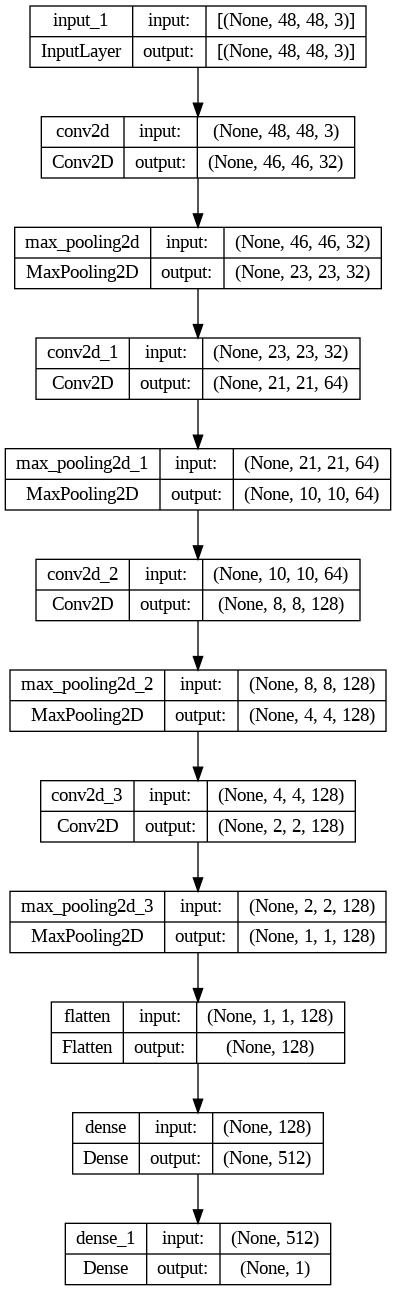

In [ ]:
#plotting model and saving it architecture picture
dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Path where the checkpoint model will be saved
model_checkpoint_path = 'model_checkpoint.h5'

# EarlyStopping callback
early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0.01, patience = 5, verbose = 1, mode = 'auto')

# ModelCheckpoint callback
model_checkpoint = ModelCheckpoint(filepath = model_checkpoint_path, monitor = 'val_loss', verbose = 1, save_best_only = True, mode = 'auto')


In [ ]:
#Fitting data into model -> training model
history = model.fit(
      train_generator,
      steps_per_epoch = train_generator.n//BATCH_SIZE,  # steps = 24381 images / batch_size
      epochs = EPOCHS,
      validation_data = validation_generator,
      validation_steps = validation_generator.n//BATCH_SIZE,
      verbose = 1,
      callbacks = [early_stopping, model_checkpoint])

Epoch 1/120
761/761 [==============================] - ETA: 0s - loss: 0.6936 - accuracy: 0.5005
Epoch 1: val_loss improved from inf to 0.69465, saving model to model_checkpoint.h5
761/761 [==============================] - 139s 182ms/step - loss: 0.6936 - accuracy: 0.5005 - val_loss: 0.6947 - val_accuracy: 0.4185
Epoch 2/120
761/761 [==============================] - ETA: 0s - loss: 0.6910 - accuracy: 0.5291
Epoch 2: val_loss improved from 0.69465 to 0.65499, saving model to model_checkpoint.h5
761/761 [==============================] - 133s 175ms/step - loss: 0.6910 - accuracy: 0.5291 - val_loss: 0.6550 - val_accuracy: 0.6106
Epoch 3/120
761/761 [==============================] - ETA: 0s - loss: 0.6765 - accuracy: 0.5666
Epoch 3: val_loss improved from 0.65499 to 0.55774, saving model to model_checkpoint.h5
761/761 [==============================] - 148s 194ms/step - loss: 0.6765 - accuracy: 0.5666 - val_loss: 0.5577 - val_accuracy: 0.7364
Epoch 4/120
761/761 [=======================

In [ ]:
#Test accuracy
_, baseline_model_accuracy = model.evaluate(
    test_generator, verbose=1)

print('Baseline test accuracy:', baseline_model_accuracy)


146/146 [==============================] - 6s 38ms/step - loss: 0.3579 - accuracy: 0.8522
Baseline test accuracy: 0.8522093296051025


In [ ]:
#save model
_, keras_file = tempfile.mkstemp('.h5')
keras.models.save_model(model, keras_file, include_optimizer=False)
print('Saved baseline model to:', keras_file)

Saved baseline model to: /tmp/tmp5r4dexzu.h5


<ipython-input-19-035c13f7cf76>:3: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  keras.models.save_model(model, keras_file, include_optimizer=False)


146/146 [==============================] - 12s 79ms/step

Classification Report:
               precision    recall  f1-score   support

       Happy       0.38      0.36      0.37      1774
   Not-happy       0.62      0.63      0.62      2888

    accuracy                           0.53      4662
   macro avg       0.50      0.50      0.50      4662
weighted avg       0.52      0.53      0.53      4662



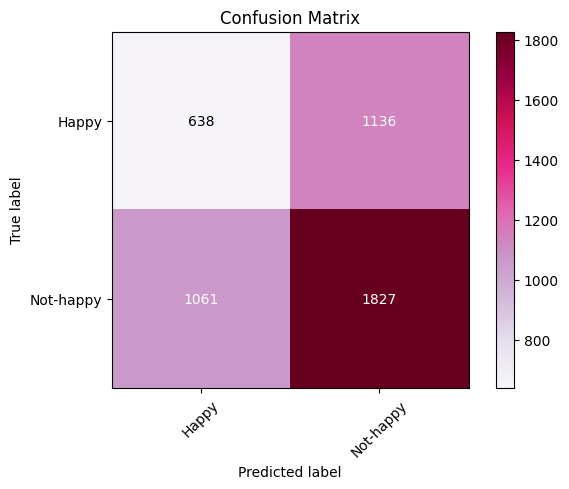

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf

# Function to generate predictions and true labels
def generate_predictions(model, validation_generator, threshold=0.5):
    validation_generator.reset()
    predictions = model.predict(validation_generator)
    binarized_predictions = (predictions > threshold).astype(int)
    true_labels = validation_generator.classes
    return binarized_predictions.flatten(), true_labels

# Function to plot the confusion matrix
def plot_confusion_matrix(conf_matrix, classes, title='Confusion Matrix', cmap=plt.cm.PuRd):
    plt.imshow(conf_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = conf_matrix.max() / 2.
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, format(conf_matrix[i, j], fmt),
                     ha="center", va="center",
                     color="white" if conf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Function to generate confusion matrix and classification report
def generate_confusion_matrix_and_report(model, validation_generator):
    predictions, true_labels = generate_predictions(model, validation_generator)
    conf_matrix = confusion_matrix(true_labels, predictions)
    report = classification_report(true_labels, predictions, target_names=['Happy', 'Not-happy'])
    return conf_matrix, report

conf_matrix, report = generate_confusion_matrix_and_report(model, validation_generator)
print("\nClassification Report:\n", report)
plot_confusion_matrix(conf_matrix, ['Happy', 'Not-happy'])


###Fine-tune pre-trained model with pruning

In [ ]:
import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 32
epochs = 4

num_images = train_generator.n
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity = 0.50,
                                                               final_sparsity = 0.80,
                                                               begin_step = 0,
                                                               end_step = end_step)}

model_for_pruning = prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer = 'adam',
              loss = keras.losses.binary_crossentropy,
              metrics = ['accuracy'])

model_for_pruning.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv2d  (None, 46, 46, 32)        1762      
  (PruneLowMagnitude)                                            
                                                                 
 prune_low_magnitude_max_po  (None, 23, 23, 32)        1         
 oling2d (PruneLowMagnitude                                      
 )                                                               
                                                                 
 prune_low_magnitude_conv2d  (None, 21, 21, 64)        36930     
 _1 (PruneLowMagnitude)                                          
                                                                 
 prune_low_magnitude_max_po  (None, 10, 10, 64)        1         
 oling2d_1 (PruneLowMagnitu                                      
 de)                                                    

In [ ]:
# Create a temporary directory to store log files
logdir = tempfile.mkdtemp()

# Set up callbacks for model pruning during training:
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir = logdir),
]

#Train model:
model_for_pruning.fit(train_generator,
                      batch_size = batch_size,
                      epochs = epochs,
                      callbacks = callbacks)

Epoch 1/4
762/762 [==============================] - 124s 154ms/step - loss: 0.4228 - accuracy: 0.8022
Epoch 2/4
762/762 [==============================] - 120s 158ms/step - loss: 0.4204 - accuracy: 0.8039
Epoch 3/4
762/762 [==============================] - 120s 158ms/step - loss: 0.4104 - accuracy: 0.8100
Epoch 4/4
762/762 [==============================] - 119s 156ms/step - loss: 0.4082 - accuracy: 0.8115


In [ ]:
#Accuracy
_, model_for_pruning_accuracy = model_for_pruning.evaluate(test_generator, verbose = 0)

print('Baseline test accuracy:', baseline_model_accuracy)
print('Pruned test accuracy:', model_for_pruning_accuracy)

Baseline test accuracy: 0.8522093296051025
Pruned test accuracy: 0.8569283485412598


###Create 3x smaller models from pruning

In [ ]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

_, pruned_keras_file = tempfile.mkstemp('.h5')
keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)
print('Saved pruned Keras model to:', pruned_keras_file)

<ipython-input-23-395ce8c5b5c5>:4: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model to: /tmp/tmpmxktaijq.h5


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
pruned_tflite_model = converter.convert()

_, pruned_tflite_file = tempfile.mkstemp('.tflite')

with open(pruned_tflite_file, 'wb') as f:
  f.write(pruned_tflite_model)

print('Saved pruned TFLite model to:', pruned_tflite_file)

Saved pruned TFLite model to: /tmp/tmpuhsieggo.tflite


In [ ]:
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)

In [ ]:
print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(keras_file)))
print("Size of gzipped pruned Keras model: %.2f bytes" % (get_gzipped_model_size(pruned_keras_file)))
print("Size of gzipped pruned TFlite model: %.2f bytes" % (get_gzipped_model_size(pruned_tflite_file)))

Size of gzipped baseline Keras model: 1144838.00 bytes
Size of gzipped pruned Keras model: 366815.00 bytes
Size of gzipped pruned TFlite model: 365435.00 bytes


###Create a 10x smaller model from combining pruning and quantization

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_and_pruned_tflite_model = converter.convert()

_, quantized_and_pruned_tflite_file = tempfile.mkstemp('.tflite')

with open(quantized_and_pruned_tflite_file, 'wb') as f:
  f.write(quantized_and_pruned_tflite_model)

print('Saved quantized and pruned TFLite model to:', quantized_and_pruned_tflite_file)

print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(keras_file)))
print("Size of gzipped pruned and quantized TFlite model: %.2f bytes" % (get_gzipped_model_size(quantized_and_pruned_tflite_file)))

Saved quantized and pruned TFLite model to: /tmp/tmpk5dtpj6l.tflite
Size of gzipped baseline Keras model: 1144838.00 bytes
Size of gzipped pruned and quantized TFlite model: 112481.00 bytes


###See persistence of accuracy from TF to TFLite

In [ ]:
def evaluate_model_using_generator_binary(interpreter, test_generator):
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    prediction_digits = []
    true_labels = []
    total_batches = test_generator.samples // test_generator.batch_size

    for i, (batch_images, batch_labels) in enumerate(test_generator):
        # Print updates every 10 batches
        if i % 10 == 0:
            print(f'Evaluated on {i} batches so far, out of {total_batches}')

        for test_image in batch_images:
            # Pre-processing: add batch dimension and convert to float32 to match with the model's input data format.
            test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
            interpreter.set_tensor(input_index, test_image)
            interpreter.invoke()

            # Post-processing: find the probability of the positive class.
            output = interpreter.get_tensor(output_index)
            probability = output[0][0]  # Assuming the output is a single sigmoid activation
            digit = 1 if probability > 0.5 else 0
            prediction_digits.append(digit)

        true_labels.extend(batch_labels)

        # Stop the loop once all batches have been processed
        if i >= total_batches - 1:
            break

    prediction_digits = np.array(prediction_digits)
    true_labels = np.array(true_labels)
    accuracy = (prediction_digits == true_labels).mean()
    return accuracy


In [ ]:
# Path to your TFLite model

# Load the model
interpreter = tf.lite.Interpreter(model_content=quantized_and_pruned_tflite_model)
interpreter.allocate_tensors()

# Assuming 'test_generator' is already set up and ready to use
accuracy = evaluate_model_using_generator_binary(interpreter, test_generator)
print('Baseline test accuracy:', baseline_model_accuracy)
print('Pruned test accuracy:', model_for_pruning_accuracy)
print('Pruned and quantized TFLite test_accuracy:', accuracy)

Evaluated on 0 batches so far, out of 145
Evaluated on 10 batches so far, out of 145
Evaluated on 20 batches so far, out of 145
Evaluated on 30 batches so far, out of 145
Evaluated on 40 batches so far, out of 145
Evaluated on 50 batches so far, out of 145
Evaluated on 60 batches so far, out of 145
Evaluated on 70 batches so far, out of 145
Evaluated on 80 batches so far, out of 145
Evaluated on 90 batches so far, out of 145
Evaluated on 100 batches so far, out of 145
Evaluated on 110 batches so far, out of 145
Evaluated on 120 batches so far, out of 145
Evaluated on 130 batches so far, out of 145
Evaluated on 140 batches so far, out of 145
Baseline test accuracy: 0.8522093296051025
Pruned test accuracy: 0.8569283485412598
Pruned and quantized TFLite test_accuracy: 0.8565874730021599
